# Notebook 5: Cython-backed NW-flex — correctness and speed

This notebook demonstrates the Cython implementation of the NW-flex DP core
and verifies that it produces identical results to the pure Python version
while achieving substantial speedups on larger inputs.

## Overview

The pure Python implementation in `dp_core.py` is designed for clarity and
easy modification. For performance-sensitive applications, we provide a
Cython-backed implementation in `fast.py` that:

1. **Encodes sequences** as integer arrays for fast indexing.
2. **Converts EP patterns** to a compact interval representation for
   efficient iteration in tight loops.
3. **Runs the DP core in C** via Cython, with typed memory views and
   disabled bounds checking.
4. **Reuses the Python traceback** to recover aligned sequences and row jumps.

Both implementations share the same API and produce identical results:

| Function | Module | Use case |
|----------|--------|----------|
| `run_flex_dp` | `dp_core.py` | Teaching, debugging, modification |
| `run_flex_dp_fast` | `fast.py` | Production, benchmarking |

This notebook is organized as follows:

1. **Setup and imports** — load modules and scoring.
2. **EP interval encoding** — explain the compact representation used by Cython.
3. **Sanity check: Python vs Cython** — verify identical scores, alignments,
   and DP matrices on a small example.
4. **Benchmarking** — compare run times across sequence lengths for both
   standard NW and single-block NW-flex.
5. **Summary** — key takeaways and usage guidance.

## Setup and imports

In [1]:
# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Core NW-flex functions
from nwflex.dp_core import FlexInput, run_flex_dp
from nwflex.fast import run_flex_dp_fast

# EP pattern builders
from nwflex.ep_patterns import build_EP_standard, build_EP_single_block
from nwflex.ep_intervals import ep_to_intervals

# Scoring and alignment helpers
from nwflex.validation import get_default_scoring
from nwflex.dp_core import AlignmentResult

# Plotting
from nwflex.plot import plot_flex_matrices, plot_score_system

# Import benchmarking utilities from validation module
from nwflex.validation import benchmark_python_vs_cython

## random number generator
rng = np.random.default_rng(888)

## validation parameters
lengths = [50, 100, 200, 400, 800]
n_samples = 10
cython_multiplier = 100

### Scoring scheme

We use the same default scoring as in the other notebooks:
match = +5, mismatch = -5, gap-open = -20, gap-extend = -1.

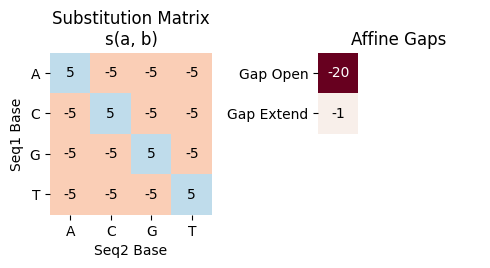

In [2]:
score_matrix, gap_open, gap_extend, alphabet_to_index = get_default_scoring()

fig = plot_score_system(score_matrix, gap_open, gap_extend, alphabet_to_index)
plt.show()

## EP interval encoding

The NW-flex DP uses **extra predecessor sets** $E(i)$ to augment the baseline
Gotoh recurrence. In Python, these are naturally represented as a list of lists:

```python
EP[i] = [r0, r1, ...]  # predecessor rows for DP row i
```

For the Cython core, iterating over Python lists would be slow. Instead, we
convert each $E(i)$ into **disjoint intervals** $[a, b]$ covering the sorted
predecessor rows. This is handled by `ep_to_intervals`:

```python
ep_counts, ep_starts, ep_ends = ep_to_intervals(EP)
```

where:
- `ep_counts[i]` = number of intervals for row $i$
- `ep_starts[i, k]`, `ep_ends[i, k]` = bounds of the $k$-th interval

This representation is compact and allows the Cython inner loops to iterate
over contiguous ranges without Python overhead.

### Example: single-block EP encoding

For a reference $X = A \cdot Z \cdot B$ with $|A| = 3$ and $|Z| = 4$ (so
$s = 3$, $e = 7$), the EP pattern is:

- Rows $s+1, \ldots, e$ (rows 4–7): $E(i) = \{s\} = \{3\}$
- Closer row $e+1$ (row 8): $E(8) = \{3, 4, 5, 6, 7\}$

In [3]:
# Build single-block EP for n=10, s=3, e=7
n, s, e = 10, 3, 7
EP = build_EP_single_block(n, s, e)

print("EP list-of-lists representation:")
for i, ep_row in enumerate(EP):
    if ep_row:
        print(f"  E({i}) = {list(ep_row)}")

# Convert to intervals
ep_counts, ep_starts, ep_ends = ep_to_intervals(EP)

print("\nInterval representation:")
for i in range(len(EP)):
    if ep_counts[i] > 0:
        intervals = [(ep_starts[i, k], ep_ends[i, k]) for k in range(ep_counts[i])]
        print(f"  Row {i}: {ep_counts[i]} interval(s) -> {intervals}")

EP list-of-lists representation:
  E(4) = [3]
  E(5) = [3]
  E(6) = [3]
  E(7) = [3]
  E(8) = [3, 4, 5, 6]

Interval representation:
  Row 4: 1 interval(s) -> [(np.int32(3), np.int32(3))]
  Row 5: 1 interval(s) -> [(np.int32(3), np.int32(3))]
  Row 6: 1 interval(s) -> [(np.int32(3), np.int32(3))]
  Row 7: 1 interval(s) -> [(np.int32(3), np.int32(3))]
  Row 8: 1 interval(s) -> [(np.int32(3), np.int32(6))]


Notice that the closer row's EP set $\{3,4,5,6,7\}$ collapses into a single
interval $[3, 7]$. This provides a simplified encoding of the EP patterns
most common in practice. A more advanced encoding scheme could more efficiently 
handle leaders and closers, at the cost of added complexity.

## Sanity check: Python vs Cython on a small example

We verify that `run_flex_dp` (Python) and `run_flex_dp_fast` (Cython) produce
identical results on a small example. We check:

1. **Scores** — the flex score $S_{\text{flex}}(X, Y)$
2. **Aligned sequences** — the gap-inserted strings
3. **Row jumps** — the EP-induced jumps recorded during traceback
4. **DP matrices** — the full $Y_g$, $M$, $X_g$ tables

We test both standard NW (EP = empty) and single-block configurations.

In [4]:
X_small = "GGGATATGGG"
Y_small = "GGGATGGG"

print(f"X = {X_small}  (n = {len(X_small)})")
print(f"Y = {Y_small}  (m = {len(Y_small)})")

X = GGGATATGGG  (n = 10)
Y = GGGATGGG  (m = 8)


### Standard NW-flex (EP = empty)

With no extra predecessors, NW-flex reduces to standard Needleman–Wunsch/Gotoh.

In [5]:
# Build FlexInput for standard NW
n = len(X_small)
EP_std = build_EP_standard(n)

cfg_std = FlexInput(
    X=X_small,
    Y=Y_small,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP_std,
    alphabet_to_index=alphabet_to_index,
)

# Run both implementations with full data
py_result = run_flex_dp(cfg_std, return_data=True)
(score_py, X_aln_py, Y_aln_py,
 path_py, jumps_py, data_py) = py_result.to_tuple()
res_fast = run_flex_dp_fast(cfg_std, return_data=True)

print("Standard NW (EP = empty):")
print(f"  Python score:  {score_py}")
print(f"  Cython score:  {res_fast.score}")
print(f"  Scores match:  {score_py == res_fast.score}")
print()
print(f"  Python X_aln:  {X_aln_py}")
print(f"  Cython X_aln:  {res_fast.X_aln}")
print(f"  X_aln match:   {X_aln_py == res_fast.X_aln}")
print()
print(f"  Python Y_aln:  {Y_aln_py}")
print(f"  Cython Y_aln:  {res_fast.Y_aln}")
print(f"  Y_aln match:   {Y_aln_py == res_fast.Y_aln}")
print()
print(f"  Row jumps (Python): {jumps_py}")
print(f"  Row jumps (Cython): {res_fast.jumps}")

Standard NW (EP = empty):
  Python score:  19.0
  Cython score:  19.0
  Scores match:  True

  Python X_aln:  GGGATATGGG
  Cython X_aln:  GGGATATGGG
  X_aln match:   True

  Python Y_aln:  GGG--ATGGG
  Cython Y_aln:  GGG--ATGGG
  Y_aln match:   True

  Row jumps (Python): []
  Row jumps (Cython): []


### Single-block NW-flex (A·Z·B)

Now we add a flexible block in the center of $X$. This exercises the EP
refinement logic in both implementations.

In [6]:
# Single-block config: Z is roughly the middle 40% of X
n = len(X_small)
block_len = max(1, int(0.4 * n))
s = (n - block_len) // 2
e = s + block_len

print(f"Block configuration: s = {s}, e = {e}")
print(f"  A = X[:{s}] = '{X_small[:s]}'")
print(f"  Z = X[{s}:{e}] = '{X_small[s:e]}'")
print(f"  B = X[{e}:] = '{X_small[e:]}'")

EP_blk = build_EP_single_block(n, s, e)

cfg_blk = FlexInput(
    X=X_small,
    Y=Y_small,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP_blk,
    alphabet_to_index=alphabet_to_index,
)

# Run both implementations
py_result_blk = run_flex_dp(cfg_blk, return_data=True)
(score_py_blk, X_aln_py_blk, Y_aln_py_blk,
 path_py_blk, jumps_py_blk, data_py_blk) = py_result_blk.to_tuple()
res_fast_blk = run_flex_dp_fast(cfg_blk, return_data=True)

print("\nSingle-block NW-flex:")
print(f"  Python score:  {score_py_blk}")
print(f"  Cython score:  {res_fast_blk.score}")
print(f"  Scores match:  {score_py_blk == res_fast_blk.score}")
print()
print(f"  Python X_aln:  {X_aln_py_blk}")
print(f"  Cython X_aln:  {res_fast_blk.X_aln}")
print(f"  X_aln match:   {X_aln_py_blk == res_fast_blk.X_aln}")
print()
print(f"  Python Y_aln:  {Y_aln_py_blk}")
print(f"  Cython Y_aln:  {res_fast_blk.Y_aln}")
print(f"  Y_aln match:   {Y_aln_py_blk == res_fast_blk.Y_aln}")
print()
print(f"  Row jumps (Python): {jumps_py_blk}")
print(f"  Row jumps (Cython): {res_fast_blk.jumps}")

Block configuration: s = 3, e = 7
  A = X[:3] = 'GGG'
  Z = X[3:7] = 'ATAT'
  B = X[7:] = 'GGG'

Single-block NW-flex:
  Python score:  40.0
  Cython score:  40.0
  Scores match:  True

  Python X_aln:  GGGATGGG
  Cython X_aln:  GGGATGGG
  X_aln match:   True

  Python Y_aln:  GGGATGGG
  Cython Y_aln:  GGGATGGG
  Y_aln match:   True

  Row jumps (Python): [RowJump(from_row=3, to_row=6, col=4, state=1)]
  Row jumps (Cython): [RowJump(from_row=3, to_row=6, col=4, state=1)]


### DP matrix comparison

We verify that the full DP matrices ($Y_g$, $M$, $X_g$) are identical
between Python and Cython. Even small floating-point discrepancies would
indicate a bug in one implementation.

In [7]:
def compare_dp_matrices(data_py, data_fast, label: str):
    """
    Compare DP matrices from Python and Cython implementations.
    
    Note: The Python implementation uses -inf for unreachable cells,
    while Cython uses a large negative sentinel value (-1e300).
    We compare only the "reachable" cells (values > -1e30).
    """
    print(f"{label}:")
    
    THRESHOLD = -1e30  # Cells below this are considered "unreachable"
    
    def compare_layer(py_arr, fast_arr):
        # Both implementations mark unreachable cells with very negative values
        py_reachable = py_arr > THRESHOLD
        fast_reachable = fast_arr > THRESHOLD
        
        # Check same cells are reachable
        if not np.array_equal(py_reachable, fast_reachable):
            return False
        
        # Compare reachable values
        mask = py_reachable
        if not mask.any():
            return True
        return np.allclose(py_arr[mask], fast_arr[mask])
    
    Yg_match = compare_layer(data_py.Yg, data_fast.Yg)
    M_match = compare_layer(data_py.M, data_fast.M)
    Xg_match = compare_layer(data_py.Xg, data_fast.Xg)
    
    print(f"  Yg matrices match: {Yg_match}")
    print(f"  M  matrices match: {M_match}")
    print(f"  Xg matrices match: {Xg_match}")
    
    if not (Yg_match and M_match and Xg_match):
        print("  WARNING: Matrix mismatch detected!")
    else:
        print("  All reachable DP cells are identical.")

compare_dp_matrices(data_py, res_fast.data, "Standard NW")
print()
compare_dp_matrices(data_py_blk, res_fast_blk.data, "Single-block NW-flex")

Standard NW:
  Yg matrices match: True
  M  matrices match: True
  Xg matrices match: True
  All reachable DP cells are identical.

Single-block NW-flex:
  Yg matrices match: True
  M  matrices match: True
  Xg matrices match: True
  All reachable DP cells are identical.


### Visualizing the DP matrices and path

As a visual sanity check, we plot the three DP layers ($Y_g$, $M$, $X_g$) with
the optimal path overlaid for both implementations. The Cython implementation
uses a sentinel value (`-1e300`) instead of `-inf` for unreachable cells, so
we convert these before plotting.

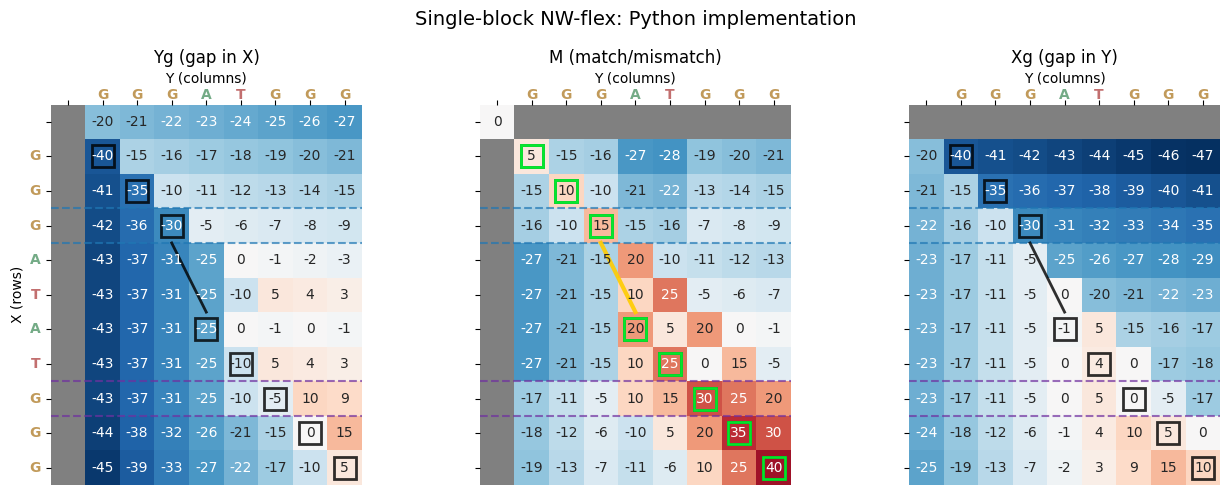

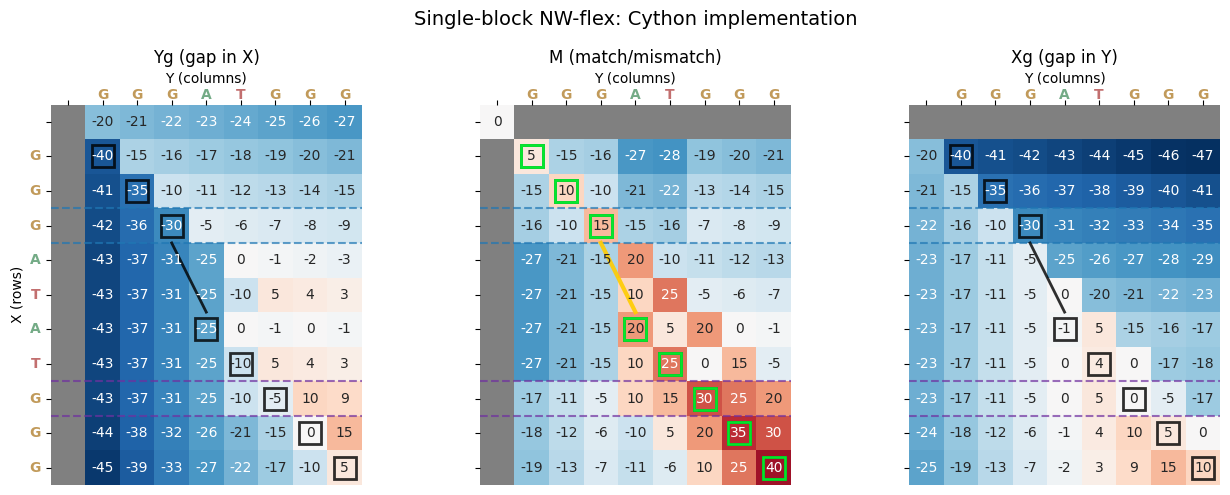

In [8]:
# Wrap Python results into an AlignmentResult for plotting
result_py_blk = AlignmentResult(
    score=score_py_blk,
    X_aln=X_aln_py_blk,
    Y_aln=Y_aln_py_blk,
    path=path_py_blk,
    jumps=jumps_py_blk,
    data=data_py_blk,
)

# Convert Cython sentinel values (-1e300) to -inf for consistent plotting
CYTHON_SENTINEL = -1e30  # Cython uses -1e300, anything below this is "unreachable"

def normalize_cython_data(data):
    """Convert Cython sentinel values to -inf for consistent representation."""
    for arr in [data.Yg, data.M, data.Xg]:
        arr[arr < CYTHON_SENTINEL] = -np.inf

# Normalize Cython data before plotting
normalize_cython_data(res_fast_blk.data)

# Plot Python result using standard plotting
fig = plot_flex_matrices(
    result=result_py_blk,
    X=X_small,
    Y=Y_small,
    s=s,
    e=e,
    marker_size=16,
    figsize=(14, 5),
)
fig.suptitle("Single-block NW-flex: Python implementation", fontsize=14)
fig.tight_layout()
plt.show()

# Plot Cython result using standard plotting
fig = plot_flex_matrices(
    result=res_fast_blk,
    X=X_small,
    Y=Y_small,
    s=s,
    e=e,
    marker_size=16,
    figsize=(14, 5),
)
fig.suptitle("Single-block NW-flex: Cython implementation", fontsize=14)
fig.tight_layout()
plt.show()

## Benchmarking: Python vs Cython

Now we compare run times on larger random sequences. We benchmark both:

1. **Standard NW-flex** (EP = empty) — baseline Needleman–Wunsch/Gotoh
2. **Single-block NW-flex** — with a flexible block in the center

Both have $O(|X| \cdot |Y|)$ time complexity; the Cython version should have
smaller constants due to:

- Typed arrays and memory views (no Python object overhead)
- Disabled bounds checking (`boundscheck=False`)
- C-level loop iteration (no Python bytecode dispatch)
- Interval-based EP iteration (fewer loop iterations)

### Benchmark results

We test sequence lengths from 50 to 800, keeping $|X| = |Y|$ for simplicity.
We use `timeit.Timer` for accurate averaging, running Cython 100× more iterations
than Python to get reliable sub-millisecond measurements.

In [9]:
# Collect benchmark data
results_std = {}  # length -> (py_avg, cy_avg)
results_blk = {}

# Run standard NW-flex benchmarks
for length in lengths:
    py_avg, cy_avg = benchmark_python_vs_cython(
        length, length, rng, mode="standard",
        n_samples=n_samples, cython_multiplier=cython_multiplier
    )
    results_std[length] = (py_avg, cy_avg)

# Print standard results table
print("Standard NW-flex (EP = empty):")
print("-" * 70)
for length in lengths:
    py_avg, cy_avg = results_std[length]
    speedup = py_avg / cy_avg
    print(f"len = {length:4d}  "
          f"Python: {py_avg:.4f}s ({n_samples} runs)  "
          f"Cython: {cy_avg:.6f}s ({n_samples * cython_multiplier} runs)  "
          f"speedup: {speedup:.1f}x")

# Run single-block NW-flex benchmarks
for length in lengths:
    py_avg, cy_avg = benchmark_python_vs_cython(
        length, length, rng, mode="single_block",
        n_samples=n_samples, cython_multiplier=cython_multiplier
    )
    results_blk[length] = (py_avg, cy_avg)

# Print single-block results table
print("\n\nSingle-block NW-flex (A·Z·B):")
print("-" * 70)
for length in lengths:
    py_avg, cy_avg = results_blk[length]
    speedup = py_avg / cy_avg
    print(f"len = {length:4d}  "
          f"Python: {py_avg:.4f}s ({n_samples} runs)  "
          f"Cython: {cy_avg:.6f}s ({n_samples * cython_multiplier} runs)  "
          f"speedup: {speedup:.1f}x")

Standard NW-flex (EP = empty):
----------------------------------------------------------------------
len =   50  Python: 0.0136s (10 runs)  Cython: 0.000055s (1000 runs)  speedup: 249.0x
len =  100  Python: 0.0541s (10 runs)  Cython: 0.000141s (1000 runs)  speedup: 384.1x
len =  200  Python: 0.2185s (10 runs)  Cython: 0.000401s (1000 runs)  speedup: 544.6x
len =  400  Python: 0.8422s (10 runs)  Cython: 0.002167s (1000 runs)  speedup: 388.7x
len =  800  Python: 3.4387s (10 runs)  Cython: 0.018930s (1000 runs)  speedup: 181.7x


Single-block NW-flex (A·Z·B):
----------------------------------------------------------------------
len =   50  Python: 0.0204s (10 runs)  Cython: 0.000068s (1000 runs)  speedup: 301.2x
len =  100  Python: 0.0766s (10 runs)  Cython: 0.000166s (1000 runs)  speedup: 461.8x
len =  200  Python: 0.3081s (10 runs)  Cython: 0.000726s (1000 runs)  speedup: 424.5x
len =  400  Python: 1.2362s (10 runs)  Cython: 0.002981s (1000 runs)  speedup: 414.7x
len =  800  Python: 4

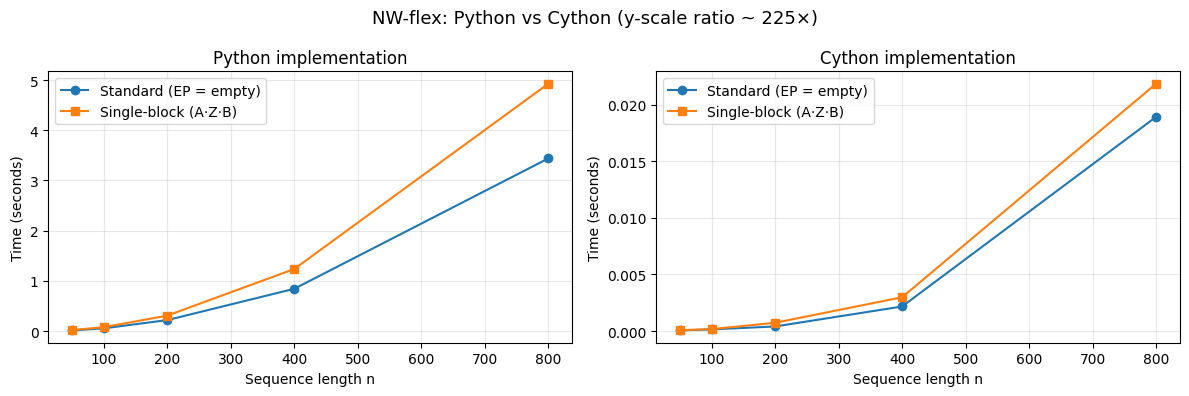


Speedups (Python avg / Cython avg):
--------------------------------------------------
Standard NW-flex:
  len =   50, speedup = 249.0x
  len =  100, speedup = 384.1x
  len =  200, speedup = 544.6x
  len =  400, speedup = 388.7x
  len =  800, speedup = 181.7x

Single-block NW-flex:
  len =   50, speedup = 301.2x
  len =  100, speedup = 461.8x
  len =  200, speedup = 424.5x
  len =  400, speedup = 414.7x
  len =  800, speedup = 225.4x


In [10]:
# Extract timing arrays for plotting
py_avgs_std = [results_std[L][0] for L in lengths]
cy_avgs_std = [results_std[L][1] for L in lengths]
py_avgs_blk = [results_blk[L][0] for L in lengths]
cy_avgs_blk = [results_blk[L][1] for L in lengths]

# Compute y-scale ratio (Python range / Cython range)
py_max = max(max(py_avgs_std), max(py_avgs_blk))
py_min = min(min(py_avgs_std), min(py_avgs_blk))
py_range = py_max - py_min

cy_max = max(max(cy_avgs_std), max(cy_avgs_blk))
cy_min = min(min(cy_avgs_std), min(cy_avgs_blk))
cy_range = cy_max - cy_min

scale_ratio = py_range / cy_range if cy_range > 0 else 1

# Plot: Python (left) vs Cython (right) with separate y-axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: Python times
ax = axes[0]
ax.plot(lengths, py_avgs_std, marker="o",
        label="Standard (EP = empty)", color="C0")
ax.plot(lengths, py_avgs_blk, marker="s",
        label="Single-block (A·Z·B)", color="C1")
ax.set_xlabel("Sequence length n")
ax.set_ylabel("Time (seconds)")
ax.set_title("Python implementation")
ax.legend()
ax.grid(True, alpha=0.3)

# Right panel: Cython times
ax = axes[1]
ax.plot(lengths, cy_avgs_std, marker="o",
        label="Standard (EP = empty)", color="C0")
ax.plot(lengths, cy_avgs_blk, marker="s",
        label="Single-block (A·Z·B)", color="C1")
ax.set_xlabel("Sequence length n")
ax.set_ylabel("Time (seconds)")
ax.set_title("Cython implementation")
ax.legend()
ax.grid(True, alpha=0.3)

title = (f"NW-flex: Python vs Cython "
         f"(y-scale ratio ~ {scale_ratio:.0f}×)")
fig.suptitle(title, fontsize=13)
plt.tight_layout()
plt.show()

# Print speedup summary
print("\nSpeedups (Python avg / Cython avg):")
print("-" * 50)
print("Standard NW-flex:")
for L in lengths:
    speedup = results_std[L][0] / results_std[L][1]
    print(f"  len = {L:4d}, speedup = {speedup:.1f}x")

print("\nSingle-block NW-flex:")
for L in lengths:
    speedup = results_blk[L][0] / results_blk[L][1]
    print(f"  len = {L:4d}, speedup = {speedup:.1f}x")

### Speedup summary

In [11]:
# Calculate speedups
speedups_std = np.array([results_std[L][0] / results_std[L][1] for L in lengths])
speedups_blk = np.array([results_blk[L][0] / results_blk[L][1] for L in lengths])

# Create summary DataFrame
summary_data = []
for n, s_std, s_blk in zip(lengths, speedups_std, speedups_blk):
    summary_data.append({
        "n": n,
        "Standard EP": f"{s_std:.0f}×",
        "Single-block EP": f"{s_blk:.0f}×"
    })

# Add mean row
summary_data.append({
    "n": "Mean",
    "Standard EP": f"{speedups_std.mean():.0f}×",
    "Single-block EP": f"{speedups_blk.mean():.0f}×"
})

df_summary = pd.DataFrame(summary_data)

print("Speedup factors (Python time / Cython time)")
print()
print(df_summary.to_string(index=False))

Speedup factors (Python time / Cython time)

   n Standard EP Single-block EP
  50        249×            301×
 100        384×            462×
 200        545×            425×
 400        389×            415×
 800        182×            225×
Mean        350×            366×


## Summary

This notebook demonstrated the Cython-backed `run_flex_dp_fast` implementation:

1. **Correctness.** The Cython core produces identical scores, aligned sequences,
   row jumps, and DP matrices as the pure Python implementation.

2. **EP encoding.** The `ep_to_intervals` function converts list-of-lists EP
   patterns into a compact interval representation for efficient C iteration.

3. **Speedup.** The Cython implementation achieves significant speedups over
   pure Python (typically 200–500x depending on sequence length and EP complexity).

4. **Same API.** Both functions take a `FlexInput` and return the same result
   structure, making them interchangeable.


The high-level alignment helpers in `aligners.py` (e.g., `align_standard`,
`align_single_block`, `align_str_phase`) use the Python core by default.

For performance-critical applications, you can construct a `FlexInput` and
call `run_flex_dp_fast` directly.